# 장고를 이용하여 게시판 앱 만들기

## 작성자 추가 및 표시하기

* 회원가입관련 기능 추가 후 작성자 정보를 넣을 수 있는 컬럼을 추가하려 한다.
* 추가를 통해 게시글을 누가 작성했는지, 어떤 작성자가 글을 작성했는지 알 수 있다.

In [ ]:
# bbsnote/models.py파일의 Board클래스에 다음을 추가해준다
class Board(models.Model):
    subject = models.CharField(max_length=200)
    content = models.TextField()
    author = models.ForeignKey(User, on_delete=models.CASCADE)
    create_date = models.DatetimeField(auto_now_add=True)
    update_date = models.DatetimeField(auto_now=True)

In [ ]:
# models.py를 수정했기 때문에 콘다 프롬포트에서 다음을 진행하여 업데이트를 해준다.
python manage.py makemigrations
python manage.py migrate

In [ ]:
# Comment클래스에도 작성자추가를 위한 변수선언을 시행해준다
class Comment(models.Model):
    # board를 외래키로 정의 on_delete=models.CASCADE는  Board객체가 삭제되면 Comment객체도 같이 삭제되도록 지정
    board = models.ForeignKey(Board, on_delete=models.CASCADE)
    content = models.TextField()
    # 위의 게시글 모델과 동일하게 작성해준다
    author = models.ForeignKey(User, on_delete=models.CASCADE)
    create_date = models.DateTimeField(auto_now_add=True)
    update_date = models.DateTimeField(auto_now=True)

In [ ]:
# 이후 models.py를 수정했기 때문에 콘다 프롬포트에서 다음을 진행하여 업데이트를 해준다.
python manage.py makemigrations
python manage.py migrate

In [ ]:
# 마찬가지로 vvsnote/views.py파일에서 comment_create함수와 board_create함수에 author를 추가해준다
# comment_create
def comment_create(request, board_id):
    board = Board.objects.get(id=board_id)
    board.comment_set.create(content=request.POST.get('content'), create_date=timezone.now(), author=request.user)
    return redirect('bbsnote:detail', board_id=board_id)

# board_create
def board_create(request):
    if request.method == 'POST':
        form = BoardForm(request.POST)
        if form.is_valid():
            board = form.save(commit=False)
            board.create_date = timezone.now()
            # author정보에 요청되었던 현재 로그인 되어있는 user정보를 출력
            board.author = request.user
            board.save()
            return redirect('bbsnote:index')
    else:
        form = BoardForm()
        return render(request, 'bbsnote/board_form.html', {'form': form})

* 이렇게만 작성하고 로그아웃 상태에서 게시글 등록버튼을 누르고 결과를 보면 다음과 같은 에러가 발생할 것이다.

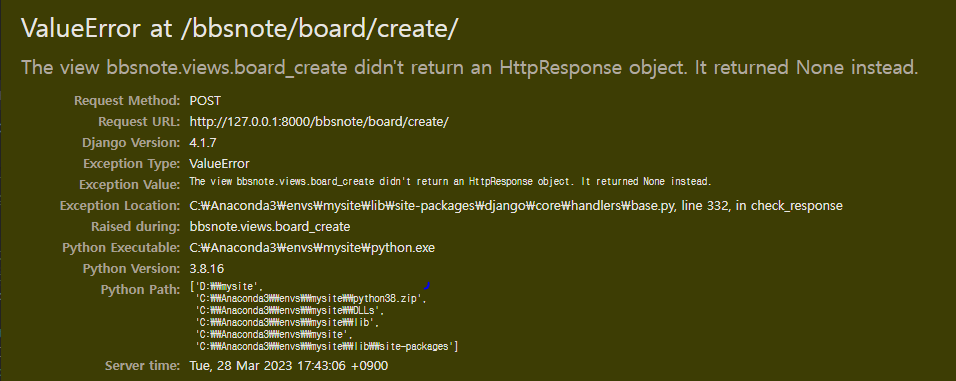

* 오류가 발생하는 이유는 로그아웃 상태에서 게시글을 등록하게되면 누가 게시했는지 모르기 때문인데, 이를 방지하기 위해서 함수 앞에 @login_required 애너테이션을 적용하여 로그인이 되었는지 우선 검사하여 오류를 방지한다.
* 로그인이 되어있지 않다면, 로그인 화면으로 이동하도록 지시하는 역할을 한다.

In [ ]:
# 아래와 같이 함수 위에 애너테이션을 적용해준다
@login_required(login_url='common:login')
def comment_create(request, board_id):
    board = Board.objects.get(id=board_id)
    board.comment_set.create(content=request.POST.get('content'), create_date=timezone.now(), author=request.user)
    return redirect('bbsnote:detail', board_id=board_id)
    
@login_required(login_url='common:login')
def board_create(request):
    if request.method == 'POST':
        form = BoardForm(request.POST)
        if form.is_valid():
            board = form.save(commit=False)
            board.create_date = timezone.now()
            # author정보에 요청되었던 현재 로그인 되어있는 user정보를 출력
            board.author = request.user
            board.save()
            return redirect('bbsnote:index')
    else:
        form = BoardForm()
        return render(request, 'bbsnote/board_form.html', {'form': form})

* board_list에 다음과 같이 조건을 추가하면, 로그인을 하지 않았을 때 게시글 등록버튼을 숨길수도 있다.

In [ ]:
<!-- 로그인을 하지 않았다면 게시글 등록버튼 숨김 -->
    {% if user.is_authenticated  %}
<a href="{% url 'bbsnote:board_create' %}" class="btn btn-primary">등록</a>
    {% endif}

* 애너테이션을 적용하면, 아래와 같이 로그아웃 상태에서 로그인을 하려 할 경우, 로그인 창으로 이동시킨다.

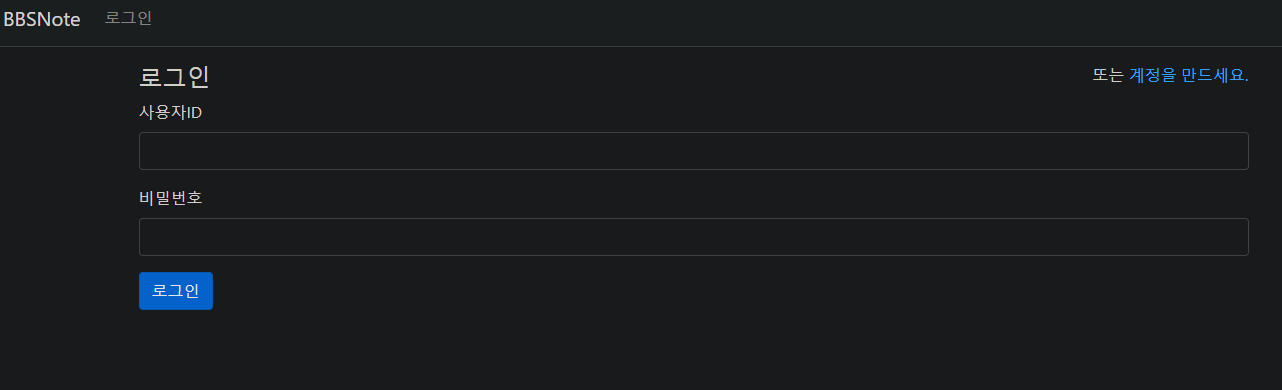

* 이 때, 검색창의 경로를 보면 경로뒤에 '?next=/bbsnote/board/create/'의 next파라미터를 확인할 수 있다.
* next파라미터의 의미는 로그인이 성공하면 나오는 다음 페이지의 경로가 'bbsnote/board/create/'로 이동된다는 것을 뜻한다.

* 로그인을 한 뒤 아래와 같이 게시글 등록'/bbsnote/board/create/'으로 돌아온 것을 알 수 있다.

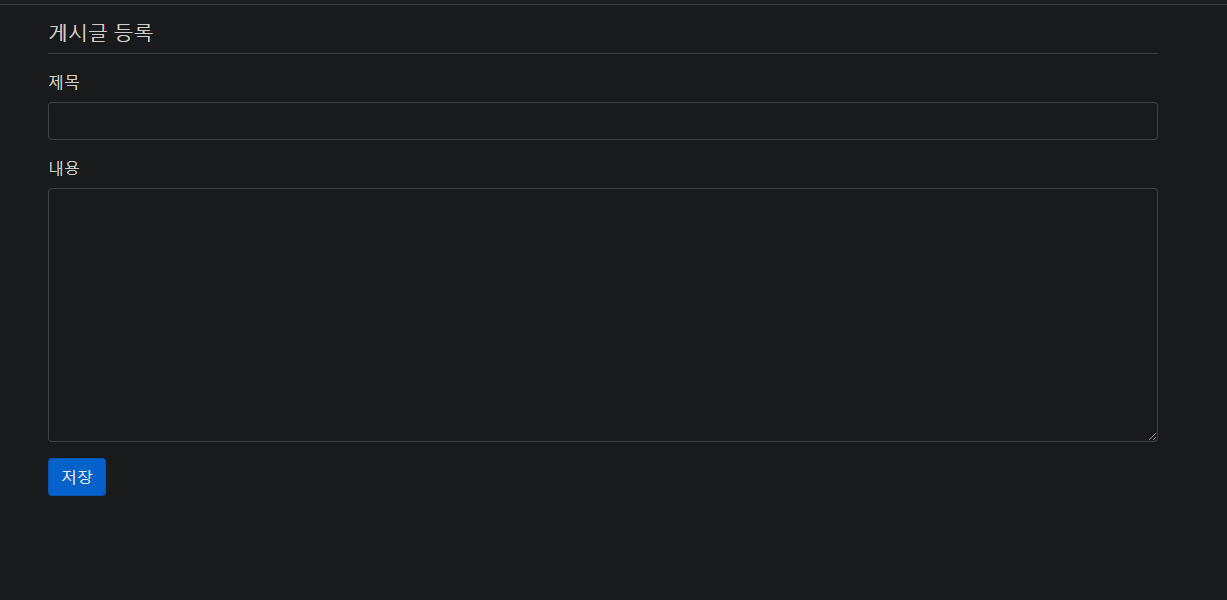

* 이와 같은 next파라미터의 정의는 login.html에 작성되있다.

In [ ]:
# template/common/login.html파일 확인
<!-- 로그인 성공후 이동되는 URL, next의 옵션이 next뒤에 명시된 URL로 이동시켜준다 -->
<input type="hidden" name="next" value="{{ next }}"> 

* 로그아웃 상태에서 글을 작성할 수 없도록 되어있지만, 댓글에서 로그인 되어있는 상태가 아니라면 작성할 수 없는 형태로 표현하기 위한 적용을 할 수 있다.

In [ ]:
# template/bbsnote/board_detail.html
# csrf_token 구문 아래에 다음과 같이 작성
<div class="form-group">
    <textarea name="content" id="content" class="form-control" rows="3"
    {% if not user.is_authenticated %}disabled{% endif %}></textarea>
</div>

* 작성자 항목을 페이지별로 추가하기위한 작업을 해준다.
* thead단락의 class아래에 작성자를 추가해주고, tbody단락의 text-center클래스 아래에 {{board.author}}의 탬플릿 변수를 선언해준다.

In [ ]:
# template/bbsnote/board_list.html파일에 추가
<div class="container my-3">
    <table class="table">
        <thead>
        <tr class="text-center thead-dark"> 
            <th></th>           
            <th style="width:50%">제목</th>
            <th>작성자</th>
            <th>작성일시</th>
        </tr>
        </thead>
        <tbody>
        {% if board_list %}
        {% for board in board_list %}
        <tr class="text-center">
            <td>{{ board_list.paginator.count|sub:board_list.start_index|sub:forloop.counter0|add:1 }}</td>
            <td class="text-left">
                <a href="{% url 'bbsnote:detail' board.id %}">{{ board.subject }}</a>                
            </td>
            <td>{{ board.author }}</td>            
            <td>{{ board.create_date }}</td>
        </tr>

* 다크모드가 설정되어 파악이 쉽지 않으나, 로그아웃상태가 되면 아래 댓글박스가 회색으로 막혀 작성이 불가능 하다.

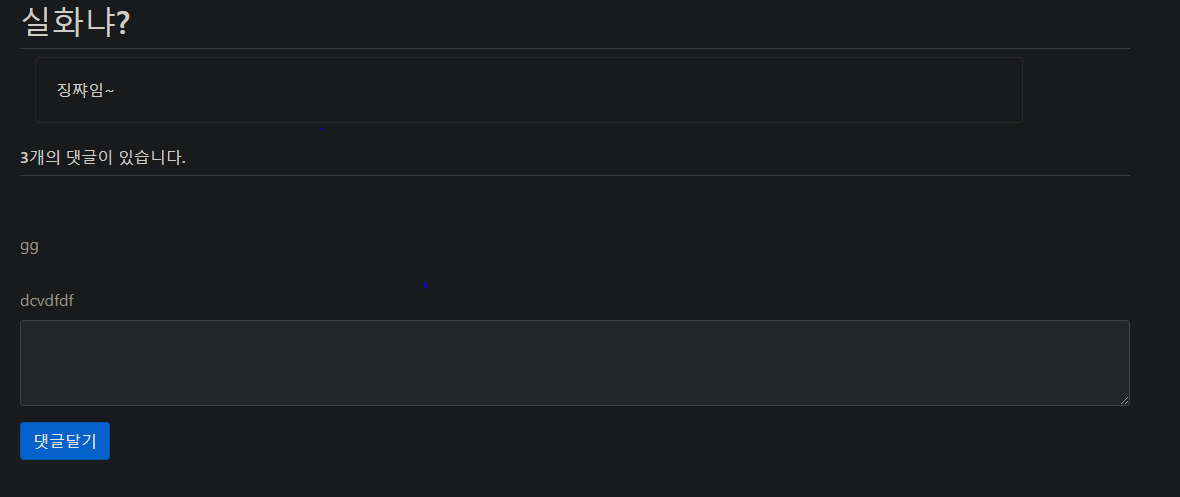

* 댓글달기를 누르게 되면, 로그인 창으로 연결되어 로그인을 진행아게 되면, 다음과 같은 오류가 발생한다.

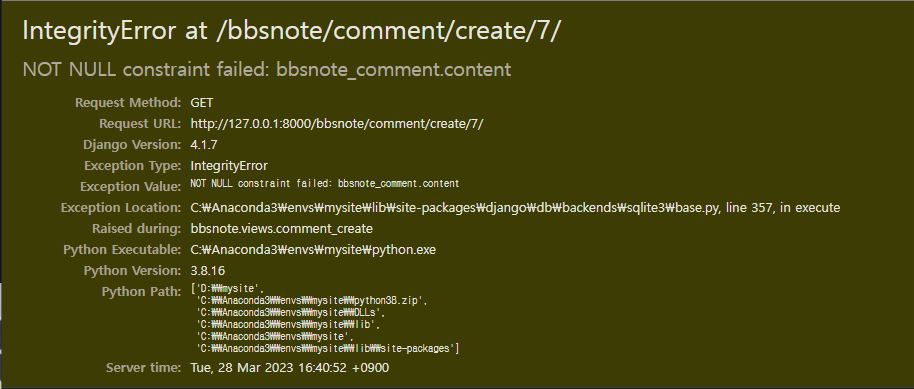

* 기존에 로그인을 하지 않고 댓글 작성을 하려 했을 경우, 데이터가 GET방식으로 입력되어 페이지 오류가 발생하게 되는 것이다.
* 그 이유는 앞서 작성한 comment_create함수에서 POST방식의 요청일 경우에만 content객체에 POST방식의 요청에 대한 content만 할당하도록 지정했었기 때문인데, 우리가 요청을 보낸 데이터는 GET방식이었기 때문에 content부분에서 Not Null 제약조건과 같은 오류가 걸리는 것이다.
* 오류를 해결하기 위해서는 다른 함수들과 마찬가지로 조건문을 사용하여 GET방식일 경우의 입력조건을 추가해주면 된다.

In [ ]:
# comment_create함수를 수정해준다
@login_required(login_url='common:login')
def comment_create(request, board_id):
    if request.method == 'POST':
        board = Board.objects.get(id=board_id)
        board.comment_set.create(content=request.POST.get('content'), create_date=timezone.now(), author=request.user)
        # return받는 경로가 같으므로 이부분은 생력해도 상관없다
        return redirect('bbsnote:detail', board_id=board_id)
    return redirect('bbsnote:detail', board_id=board_id)

* 함수를 수정하고, 웹 사이트를 새로고침하고 로그아웃 상태에서 댓글달기 -> 로그인 -> 로그인 성공 후 댓글달기를 해보면 정상적으로 작동되는 것을 알 수 있다.